In [ ]:
!nvidia-smi

Wed Apr 21 01:10:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 460kB 52.6MB/s 
     |████████████████████████████████| 92kB 13.2MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


## 곡의 note embedding을 이용해 주요 구절을 추출하는 모델

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import os

In [5]:
from google.colab import drive

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
import pickle

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import nltk

In [9]:
from konlpy.tag import Okt

In [57]:
from collections import Counter

In [10]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [11]:
%cd /content/drive/MyDrive/Colab Notebooks/Project/code/songs

/content/drive/MyDrive/Colab Notebooks/Project/code/songs


## 노래 데이터 로드

In [131]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/project_data/Crawling_Lyrics.csv')

In [132]:
df.head()

,title,singer,lyrics
0,너희는 (Feat. 김광률),이은영,너희는 하나님의 택하신\n거룩하고 사랑스러운 자니 \n긍율과 자비와 \n겸손과 온유...
1,봄날은 간다 (Bonus Track),김윤아,눈을 감으면 문득 그리운 날의 기억 \n아직까지도 마음이 저려 오는 건 \n\n그건...
2,Going Home,김윤아,집으로 돌아가는 길에\n지는 햇살에 마음을 맡기고\n나는 너의 일을 떠올리며\n수많...
3,야상곡 (夜想曲),김윤아,바람이 부는 것은 더운 내 맘 삭여주려 \n계절이 다 가도록 나는 애만 태우네 \n...
4,길,김윤아,아무도 가르쳐 주지 않아\n이 길이 옳은지 다른 길로 가야 할지\n난 저길 저 끝에...


## 전처리

### 결측치 제거

In [133]:
df.dropna(axis=0, inplace = True)

In [134]:
df['lyrics'] = df['lyrics'].str.replace('[^가-힣]' , ' ')

In [135]:
df.head()

,title,singer,lyrics
0,너희는 (Feat. 김광률),이은영,너희는 하나님의 택하신 거룩하고 사랑스러운 자니 긍율과 자비와 겸손과 온유와 오...
1,봄날은 간다 (Bonus Track),김윤아,눈을 감으면 문득 그리운 날의 기억 아직까지도 마음이 저려 오는 건 그건 아마...
2,Going Home,김윤아,집으로 돌아가는 길에 지는 햇살에 마음을 맡기고 나는 너의 일을 떠올리며 수많은 생...
3,야상곡 (夜想曲),김윤아,바람이 부는 것은 더운 내 맘 삭여주려 계절이 다 가도록 나는 애만 태우네 꽃잎...
4,길,김윤아,아무도 가르쳐 주지 않아 이 길이 옳은지 다른 길로 가야 할지 난 저길 저 끝에 다...


In [136]:
lyrics = list(df['lyrics'])

In [153]:
stopwords = []
with open('./stop_words.txt' , 'r') as f:
  for line in f:
    a = line.split('\n')
    stopwords.append(a[0])

In [154]:
stopwords

['아',
 '휴',
 '아이구',
 '아이쿠',
 '아이고',
 '어',
 '나',
 '우리',
 '저희',
 '따라',
 '의해',
 '을',
 '를',
 '에',
 '의',
 '가',
 '으로',
 '로',
 '에게',
 '뿐이다',
 '의거하여',
 '근거하여',
 '입각하여',
 '기준으로',
 '예하면',
 '예를 들면',
 '예를 들자면',
 '저',
 '소인',
 '소생',
 '저희',
 '지말고',
 '하지마',
 '하지마라',
 '다른',
 '물론',
 '또한',
 '그리고',
 '비길수 없다',
 '해서는 안된다',
 '뿐만 아니라',
 '만이 아니다',
 '만은 아니다',
 '막론하고',
 '관계없이',
 '그치지 않다',
 '그러나',
 '그런데',
 '하지만',
 '든간에',
 '논하지 않다',
 '따지지 않다',
 '설사',
 '비록',
 '더라도',
 '아니면',
 '만 못하다',
 '하는 편이 낫다',
 '불문하고',
 '향하여',
 '향해서',
 '향하다',
 '쪽으로',
 '틈타',
 '이용하여',
 '타다',
 '오르다',
 '제외하고',
 '이 외에',
 '이 밖에',
 '하여야',
 '비로소',
 '한다면 몰라도',
 '외에도',
 '이곳',
 '여기',
 '부터',
 '기점으로',
 '따라서',
 '할 생각이다',
 '하려고하다',
 '이리하여',
 '그리하여',
 '그렇게 함으로써',
 '하지만',
 '일때',
 '할때',
 '앞에서',
 '중에서',
 '보는데서',
 '으로써',
 '로써',
 '까지',
 '해야한다',
 '일것이다',
 '반드시',
 '할줄알다',
 '할수있다',
 '할수있어',
 '임에 틀림없다',
 '한다면',
 '등',
 '등등',
 '제',
 '겨우',
 '단지',
 '다만',
 '할뿐',
 '딩동',
 '댕그',
 '대해서',
 '대하여',
 '대하면',
 '훨씬',
 '얼마나',
 '얼마만큼',
 '얼마큼',
 '남짓',
 '여',
 '얼마간',
 '약간',
 '다소',
 '좀',
 '조

In [17]:
stopwords = ['의', '가', '이', '은', '들', '는',
             '좀', '잘', '걍', '과', '도',
             '를', '으로', '자', '에', '와', '한', '하다']


stop_words = "아무거나 아무렇게나 어찌하든지 같다 비슷하다 예컨대 이럴정도로 하면 아니거든"
stop_words = stop_words.split(' ')



In [ ]:
lyrics

In [161]:
%%time

okt = Okt()
tokenized_data = []

for lyric in lyrics :
  temp_X = okt.morphs(lyric, stem = False) # 토큰화(형태소 별로 나눠짐)
  temp_X = [word for word in temp_X if len(word) > 1 and not word in stopwords] # 불용어 제거
  tokenized_data.append(temp_X)

CPU times: user 13.6 s, sys: 32 ms, total: 13.6 s
Wall time: 13.2 s


In [51]:
len(tokenized_data)

700

In [162]:
tokenized_data

[['하나님',
  '하신',
  '거룩하고',
  '사랑스러운',
  '자니',
  '긍율',
  '자비',
  '겸손',
  '온유',
  '오래',
  '참음',
  '가득하길',
  '하나님',
  '하신',
  '거룩하고',
  '사랑스러운',
  '자니',
  '서로',
  '용서',
  '하고',
  '모든',
  '사랑',
  '더하라',
  '말씀',
  '마음속',
  '성히',
  '하며',
  '찬미',
  '감사함으로',
  '찬양',
  '찌라',
  '하나님',
  '하신',
  '거룩하고',
  '사랑스러운',
  '자니',
  '긍율',
  '자비',
  '겸손',
  '온유',
  '오래',
  '참음',
  '가득하길',
  '하나님',
  '하신',
  '거룩하고',
  '사랑스러운',
  '자니',
  '서로',
  '용서',
  '하고',
  '모든',
  '사랑',
  '더하라',
  '말씀',
  '마음속',
  '성히',
  '하며',
  '찬미',
  '감사함으로',
  '찬양',
  '찌라',
  '평강',
  '하여',
  '되었으니',
  '언제나',
  '감사하는',
  '되어라',
  '감사해',
  '말씀',
  '마음속',
  '성히',
  '하며',
  '찬미',
  '감사함으로',
  '찬양',
  '찌라',
  '찬양',
  '찌라',
  '찬양',
  '찌라',
  '찬양',
  '찌라'],
 ['감으면',
  '문득',
  '그리운',
  '기억',
  '아직',
  '마음',
  '저려',
  '오는',
  '그건',
  '아마',
  '사람',
  '피고',
  '지는',
  '꽃처럼',
  '아름다워서',
  '슬프기',
  '때문',
  '거야',
  '아마도',
  '봄날',
  '가네',
  '무심히도',
  '꽃잎',
  '지네',
  '바람',
  '머물',
  '없던',
  '아름다운',
  '사람',
  '가만히',
  '눈감으면',
  '잡힐',
  '같은',
  '아련히'

### 빈도수가 높은 단어 순서로 정렬

In [163]:
words = sum(tokenized_data, [])

print(words)

['하나님', '하신', '거룩하고', '사랑스러운', '자니', '긍율', '자비', '겸손', '온유', '오래', '참음', '가득하길', '하나님', '하신', '거룩하고', '사랑스러운', '자니', '서로', '용서', '하고', '모든', '사랑', '더하라', '말씀', '마음속', '성히', '하며', '찬미', '감사함으로', '찬양', '찌라', '하나님', '하신', '거룩하고', '사랑스러운', '자니', '긍율', '자비', '겸손', '온유', '오래', '참음', '가득하길', '하나님', '하신', '거룩하고', '사랑스러운', '자니', '서로', '용서', '하고', '모든', '사랑', '더하라', '말씀', '마음속', '성히', '하며', '찬미', '감사함으로', '찬양', '찌라', '평강', '하여', '되었으니', '언제나', '감사하는', '되어라', '감사해', '말씀', '마음속', '성히', '하며', '찬미', '감사함으로', '찬양', '찌라', '찬양', '찌라', '찬양', '찌라', '찬양', '찌라', '감으면', '문득', '그리운', '기억', '아직', '마음', '저려', '오는', '그건', '아마', '사람', '피고', '지는', '꽃처럼', '아름다워서', '슬프기', '때문', '거야', '아마도', '봄날', '가네', '무심히도', '꽃잎', '지네', '바람', '머물', '없던', '아름다운', '사람', '가만히', '눈감으면', '잡힐', '같은', '아련히', '마음', '아픈', '추억', '같은', '오고', '피고', '지고', '피고', '아름다워서', '너무나', '슬픈', '이야기', '봄날', '가네', '무심히도', '꽃잎', '지네', '바람', '머물', '없던', '아름다운', '사람', '가만히', '눈감으면', '잡힐', '같은', '아련히', '마음', '아픈', '추억', '같은', '감으면', '문득', '그리운', '기억', '아직', '

In [164]:
vocab = Counter(words)

print(vocab)

Counter({'그대': 1084, '사랑': 1046, '나를': 477, '사람': 446, '마음': 405, '다시': 379, '처럼': 347, '이제': 311, '없는': 304, '너무': 288, '오늘': 287, '세상': 284, '아무': 245, '생각': 243, '내게': 231, '눈물': 216, '기억': 209, '하나': 204, '이렇게': 202, '있어': 194, '하고': 189, '지금': 188, '모습': 184, '가슴': 183, '하는': 182, '있는': 179, '노래': 177, '하루': 172, '하지': 169, '같은': 161, '모든': 158, '없이': 155, '없어': 152, '혼자': 149, '거야': 146, '그냥': 146, '버린': 143, '바람': 142, '해도': 142, '처음': 138, '우린': 137, '추억': 136, '했던': 131, '이별': 131, '하늘': 122, '얼굴': 119, '많은': 115, '그녀': 115, '서로': 114, '나도': 113, '언제나': 107, '좋아': 102, '그렇게': 102, '보고': 101, '마지막': 98, '매일': 97, '수가': 95, '한번': 95, '라도': 91, '말아요': 91, '순간': 90, '어제': 89, '그런': 87, '가끔': 86, '가는': 85, '지난': 85, '얘기': 84, '소리': 84, '거리': 83, '이유': 83, '보다': 82, '아침': 81, '이미': 80, '아직': 78, '우우': 76, '친구': 76, '않아': 75, '같아': 74, '목소리': 74, '상처': 74, '보면': 74, '걸까': 73, '싶어': 73, '영원히': 73, '위로': 72, '가득': 72, '많이': 70, '미소': 70, '작은': 70, '바보': 69, '에도': 69, '이야': 69, '세월': 69

In [165]:
vocab_size = 2165

vocab = vocab.most_common(vocab_size)

vocab

[('그대', 1084),
 ('사랑', 1046),
 ('나를', 477),
 ('사람', 446),
 ('마음', 405),
 ('다시', 379),
 ('처럼', 347),
 ('이제', 311),
 ('없는', 304),
 ('너무', 288),
 ('오늘', 287),
 ('세상', 284),
 ('아무', 245),
 ('생각', 243),
 ('내게', 231),
 ('눈물', 216),
 ('기억', 209),
 ('하나', 204),
 ('이렇게', 202),
 ('있어', 194),
 ('하고', 189),
 ('지금', 188),
 ('모습', 184),
 ('가슴', 183),
 ('하는', 182),
 ('있는', 179),
 ('노래', 177),
 ('하루', 172),
 ('하지', 169),
 ('같은', 161),
 ('모든', 158),
 ('없이', 155),
 ('없어', 152),
 ('혼자', 149),
 ('거야', 146),
 ('그냥', 146),
 ('버린', 143),
 ('바람', 142),
 ('해도', 142),
 ('처음', 138),
 ('우린', 137),
 ('추억', 136),
 ('했던', 131),
 ('이별', 131),
 ('하늘', 122),
 ('얼굴', 119),
 ('많은', 115),
 ('그녀', 115),
 ('서로', 114),
 ('나도', 113),
 ('언제나', 107),
 ('좋아', 102),
 ('그렇게', 102),
 ('보고', 101),
 ('마지막', 98),
 ('매일', 97),
 ('수가', 95),
 ('한번', 95),
 ('라도', 91),
 ('말아요', 91),
 ('순간', 90),
 ('어제', 89),
 ('그런', 87),
 ('가끔', 86),
 ('가는', 85),
 ('지난', 85),
 ('얘기', 84),
 ('소리', 84),
 ('거리', 83),
 ('이유', 83),
 ('보다', 82),
 ('아침', 81),
 ('

### 높은 빈도수를 가진 단어일수록 낮은 정수 인덱스 부여

In [166]:
word_to_index = {}

i = 0

for (word, frequency) in vocab:
  i += 1
  word_to_index[word] = i

print(word_to_index)

{'그대': 1, '사랑': 2, '나를': 3, '사람': 4, '마음': 5, '다시': 6, '처럼': 7, '이제': 8, '없는': 9, '너무': 10, '오늘': 11, '세상': 12, '아무': 13, '생각': 14, '내게': 15, '눈물': 16, '기억': 17, '하나': 18, '이렇게': 19, '있어': 20, '하고': 21, '지금': 22, '모습': 23, '가슴': 24, '하는': 25, '있는': 26, '노래': 27, '하루': 28, '하지': 29, '같은': 30, '모든': 31, '없이': 32, '없어': 33, '혼자': 34, '거야': 35, '그냥': 36, '버린': 37, '바람': 38, '해도': 39, '처음': 40, '우린': 41, '추억': 42, '했던': 43, '이별': 44, '하늘': 45, '얼굴': 46, '많은': 47, '그녀': 48, '서로': 49, '나도': 50, '언제나': 51, '좋아': 52, '그렇게': 53, '보고': 54, '마지막': 55, '매일': 56, '수가': 57, '한번': 58, '라도': 59, '말아요': 60, '순간': 61, '어제': 62, '그런': 63, '가끔': 64, '가는': 65, '지난': 66, '얘기': 67, '소리': 68, '거리': 69, '이유': 70, '보다': 71, '아침': 72, '이미': 73, '아직': 74, '우우': 75, '친구': 76, '않아': 77, '같아': 78, '목소리': 79, '상처': 80, '보면': 81, '걸까': 82, '싶어': 83, '영원히': 84, '위로': 85, '가득': 86, '많이': 87, '미소': 88, '작은': 89, '바보': 90, '에도': 91, '이야': 92, '세월': 93, '정말': 94, '않고': 95, '위해': 96, '내일': 97, '웃음': 98, '아직도': 99, '있게': 100,

In [167]:
index_to_word = {k:v for v, k in word_to_index.items()}

print(index_to_word)

{1: '그대', 2: '사랑', 3: '나를', 4: '사람', 5: '마음', 6: '다시', 7: '처럼', 8: '이제', 9: '없는', 10: '너무', 11: '오늘', 12: '세상', 13: '아무', 14: '생각', 15: '내게', 16: '눈물', 17: '기억', 18: '하나', 19: '이렇게', 20: '있어', 21: '하고', 22: '지금', 23: '모습', 24: '가슴', 25: '하는', 26: '있는', 27: '노래', 28: '하루', 29: '하지', 30: '같은', 31: '모든', 32: '없이', 33: '없어', 34: '혼자', 35: '거야', 36: '그냥', 37: '버린', 38: '바람', 39: '해도', 40: '처음', 41: '우린', 42: '추억', 43: '했던', 44: '이별', 45: '하늘', 46: '얼굴', 47: '많은', 48: '그녀', 49: '서로', 50: '나도', 51: '언제나', 52: '좋아', 53: '그렇게', 54: '보고', 55: '마지막', 56: '매일', 57: '수가', 58: '한번', 59: '라도', 60: '말아요', 61: '순간', 62: '어제', 63: '그런', 64: '가끔', 65: '가는', 66: '지난', 67: '얘기', 68: '소리', 69: '거리', 70: '이유', 71: '보다', 72: '아침', 73: '이미', 74: '아직', 75: '우우', 76: '친구', 77: '않아', 78: '같아', 79: '목소리', 80: '상처', 81: '보면', 82: '걸까', 83: '싶어', 84: '영원히', 85: '위로', 86: '가득', 87: '많이', 88: '미소', 89: '작은', 90: '바보', 91: '에도', 92: '이야', 93: '세월', 94: '정말', 95: '않고', 96: '위해', 97: '내일', 98: '웃음', 99: '아직도', 100: '있게',

## 라흐마니노프의 곡

In [70]:
# 하이퍼퍼라미터
embed_size = 200

# 데이터 이름
data_name = 'Rachmaninov'
pickle_name = 'Rachmaninov_pickle'

In [71]:
with open('./note_embeddings.pickle' , 'rb') as f:
  note_embedding = pickle.load(f)

In [ ]:
# with open('note_to_int.pickle' , 'rb') as f:
#   note_to_int = pickle.load(f)

In [72]:
with open('./{}_notes'.format(pickle_name), 'rb') as f:
  notes = pickle.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
with open('./{}_durations'.format(pickle_name), 'rb') as f:
  durations = pickle.load(f)

In [73]:
len(note_embedding)

2165

In [ ]:
notes

## 곡의 note를 구절 단위로 리스트화

In [74]:
seq_len = 20
sentences = []

last_idx = -1

for i, note in enumerate(notes):

  if i < last_idx : continue

  if note == 'START':
    continue

  else:
    last_idx = i + seq_len
    sentences.append(notes[i:i + seq_len ])

In [75]:
sentences

[['A3.A1.A2',
  'G#3.G#1.G#2',
  'C#3.C#1.C#2',
  'G#4.C#4.C#5.E4.G#3.E3',
  'B4.E4.E5.G#4.B3.G#3',
  'B-4.E-5.E-4.G4.B-3.G3',
  'A3.A1.A2',
  'A4.D4.D5.F#4.C4.F#3',
  'G#3.G#1.G#2',
  'F#4.C5.C4.E-4.F#3.E-3',
  'C#3.C#1.C#2',
  'G#4.C#4.C#5.E4.G#3.E3',
  'B4.E5.E4.G#4.B3.G#3',
  'E-5.E-4.B-4.G4.B-3.G3',
  'A3.A1.A2',
  'D5.A4.D4.F#4.C4.F#3',
  'G#3.G#1.G#2',
  'C5.C4.F#4.E-4.F#3.E-3',
  'C#3.C#1.C#2',
  'G#4.C#5.C#4.E4.G#3.E3'],
 ['G#5.G#4.C#5.B4.C#4.B3',
  'F#5.C#5.F#4.A4.C#4.A3',
  'C4.C2.C3',
  'E4.A4.E5.F#4.A3.F#3',
  'B3.B1.B2',
  'E-5.E-4.A4.F#4.A3.F#3',
  'E3.E1.E2',
  'E5.E4.B4.G#4.B3.G#3',
  'B5.E5.B4.E-5.E4.E-4',
  'E5.A5.A4.C#5.E4.C#4',
  'E4.E2.E3',
  'G#4.G#5.C#5.B-4.C#4.B-3',
  'E-4.E-2.E-3',
  'C#5.G4.G5.B-4.C#4.B-3',
  'G#3',
  'G#1.G#2',
  'G#4.G#5.E-5.B4.E-4.B3',
  'E5.A5.A4.C#5.E4.C#4',
  'F#5.F#4.C#5.A4.C#4.A3',
  'G#5.G#4.E-5.B4.E-4.B3'],
 ['E4.B4.E5.G#4.B3',
  'F#4.F#5.C#5.A4.C#4.A3',
  'A4.E-5.E-4.F#4.A3.F#3',
  'E5.E4.B4.G#4.B3.G#3',
  'E5.E4.B4.G#4.B3.G#3',
  

In [76]:
len(sentences)

466

### 빈도가 높은 note 순으로 정렬

In [78]:
note_list = sum(sentences, [])

print(note_list)

['A3.A1.A2', 'G#3.G#1.G#2', 'C#3.C#1.C#2', 'G#4.C#4.C#5.E4.G#3.E3', 'B4.E4.E5.G#4.B3.G#3', 'B-4.E-5.E-4.G4.B-3.G3', 'A3.A1.A2', 'A4.D4.D5.F#4.C4.F#3', 'G#3.G#1.G#2', 'F#4.C5.C4.E-4.F#3.E-3', 'C#3.C#1.C#2', 'G#4.C#4.C#5.E4.G#3.E3', 'B4.E5.E4.G#4.B3.G#3', 'E-5.E-4.B-4.G4.B-3.G3', 'A3.A1.A2', 'D5.A4.D4.F#4.C4.F#3', 'G#3.G#1.G#2', 'C5.C4.F#4.E-4.F#3.E-3', 'C#3.C#1.C#2', 'G#4.C#5.C#4.E4.G#3.E3', 'G#5.G#4.C#5.B4.C#4.B3', 'F#5.C#5.F#4.A4.C#4.A3', 'C4.C2.C3', 'E4.A4.E5.F#4.A3.F#3', 'B3.B1.B2', 'E-5.E-4.A4.F#4.A3.F#3', 'E3.E1.E2', 'E5.E4.B4.G#4.B3.G#3', 'B5.E5.B4.E-5.E4.E-4', 'E5.A5.A4.C#5.E4.C#4', 'E4.E2.E3', 'G#4.G#5.C#5.B-4.C#4.B-3', 'E-4.E-2.E-3', 'C#5.G4.G5.B-4.C#4.B-3', 'G#3', 'G#1.G#2', 'G#4.G#5.E-5.B4.E-4.B3', 'E5.A5.A4.C#5.E4.C#4', 'F#5.F#4.C#5.A4.C#4.A3', 'G#5.G#4.E-5.B4.E-4.B3', 'E4.B4.E5.G#4.B3', 'F#4.F#5.C#5.A4.C#4.A3', 'A4.E-5.E-4.F#4.A3.F#3', 'E5.E4.B4.G#4.B3.G#3', 'E5.E4.B4.G#4.B3.G#3', 'F#4.C#5.F#5.A4.C#4.A3', 'E-4.E-5.A4.F#4.A3.F#3', 'B4.E5.E4.G#4.B3.G#3', 'C#5.C#4.G#4.E4.G#3.

In [79]:
note_count = Counter(note_list)

print(note_count)

Counter({'D3': 179, 'B-3': 172, 'C#3': 164, 'B-2': 155, 'F3': 155, 'G3': 151, 'D4': 145, 'G4': 132, 'C#4': 130, 'C#5': 127, 'A2': 123, 'G#3': 121, 'E-4': 121, 'F4': 114, 'A3': 113, 'E-5': 109, 'F5': 107, 'G#2': 103, 'C4': 102, 'B-4': 101, 'F2': 93, 'G#4': 92, 'F#4': 91, 'G2': 91, 'C#2': 90, 'D5': 90, 'B-5': 90, 'E3': 89, 'F#3': 86, 'A4': 84, 'C5': 81, 'G5': 74, 'G#5': 73, 'F#5': 71, 'E-3': 71, 'E4': 69, 'B3': 67, 'B4': 62, 'A1': 61, 'C3': 53, 'C#1': 53, 'E5': 48, 'A5': 46, 'C6': 44, 'E-6': 43, 'D2': 43, 'G6': 42, 'E2': 40, 'B2': 37, 'C#6': 36, 'B5': 35, 'D6': 35, 'B-1': 35, 'F6': 33, 'E-2': 32, 'F#2': 30, 'START': 28, 'D4.B-3': 26, 'B-5.B-4': 23, 'G#1': 23, 'B-3.D4.D3.G3': 23, 'G#6': 23, 'B-6': 21, 'B-2.B-1': 19, 'D4.D3': 19, 'B-4.D5': 18, 'C2': 18, 'D4.F4': 17, 'E-4.E-3': 17, 'F#6': 17, 'C#1.C#2': 16, 'B-4.B-5': 16, 'G3.G1.G2': 15, 'G4.G3': 15, 'C5.E-5': 14, 'A2.A1': 14, 'F1.F2': 14, 'B-4.B-3': 14, 'C#6.C#5': 14, 'B-3.B-2': 14, 'E-3.G3': 14, 'C#3.C#1.C#2': 13, 'E4.C#4': 13, 'G5.G4': 1

In [80]:
vocab_size = 2165

note_count = note_count.most_common(vocab_size)

note_count

[('D3', 179),
 ('B-3', 172),
 ('C#3', 164),
 ('B-2', 155),
 ('F3', 155),
 ('G3', 151),
 ('D4', 145),
 ('G4', 132),
 ('C#4', 130),
 ('C#5', 127),
 ('A2', 123),
 ('G#3', 121),
 ('E-4', 121),
 ('F4', 114),
 ('A3', 113),
 ('E-5', 109),
 ('F5', 107),
 ('G#2', 103),
 ('C4', 102),
 ('B-4', 101),
 ('F2', 93),
 ('G#4', 92),
 ('F#4', 91),
 ('G2', 91),
 ('C#2', 90),
 ('D5', 90),
 ('B-5', 90),
 ('E3', 89),
 ('F#3', 86),
 ('A4', 84),
 ('C5', 81),
 ('G5', 74),
 ('G#5', 73),
 ('F#5', 71),
 ('E-3', 71),
 ('E4', 69),
 ('B3', 67),
 ('B4', 62),
 ('A1', 61),
 ('C3', 53),
 ('C#1', 53),
 ('E5', 48),
 ('A5', 46),
 ('C6', 44),
 ('E-6', 43),
 ('D2', 43),
 ('G6', 42),
 ('E2', 40),
 ('B2', 37),
 ('C#6', 36),
 ('B5', 35),
 ('D6', 35),
 ('B-1', 35),
 ('F6', 33),
 ('E-2', 32),
 ('F#2', 30),
 ('START', 28),
 ('D4.B-3', 26),
 ('B-5.B-4', 23),
 ('G#1', 23),
 ('B-3.D4.D3.G3', 23),
 ('G#6', 23),
 ('B-6', 21),
 ('B-2.B-1', 19),
 ('D4.D3', 19),
 ('B-4.D5', 18),
 ('C2', 18),
 ('D4.F4', 17),
 ('E-4.E-3', 17),
 ('F#6', 17),


In [81]:
note_to_index = {}

i = 0

for (note, frequency) in note_count:
  i += 1
  note_to_index[note] = i

print(note_to_index)

{'D3': 1, 'B-3': 2, 'C#3': 3, 'B-2': 4, 'F3': 5, 'G3': 6, 'D4': 7, 'G4': 8, 'C#4': 9, 'C#5': 10, 'A2': 11, 'G#3': 12, 'E-4': 13, 'F4': 14, 'A3': 15, 'E-5': 16, 'F5': 17, 'G#2': 18, 'C4': 19, 'B-4': 20, 'F2': 21, 'G#4': 22, 'F#4': 23, 'G2': 24, 'C#2': 25, 'D5': 26, 'B-5': 27, 'E3': 28, 'F#3': 29, 'A4': 30, 'C5': 31, 'G5': 32, 'G#5': 33, 'F#5': 34, 'E-3': 35, 'E4': 36, 'B3': 37, 'B4': 38, 'A1': 39, 'C3': 40, 'C#1': 41, 'E5': 42, 'A5': 43, 'C6': 44, 'E-6': 45, 'D2': 46, 'G6': 47, 'E2': 48, 'B2': 49, 'C#6': 50, 'B5': 51, 'D6': 52, 'B-1': 53, 'F6': 54, 'E-2': 55, 'F#2': 56, 'START': 57, 'D4.B-3': 58, 'B-5.B-4': 59, 'G#1': 60, 'B-3.D4.D3.G3': 61, 'G#6': 62, 'B-6': 63, 'B-2.B-1': 64, 'D4.D3': 65, 'B-4.D5': 66, 'C2': 67, 'D4.F4': 68, 'E-4.E-3': 69, 'F#6': 70, 'C#1.C#2': 71, 'B-4.B-5': 72, 'G3.G1.G2': 73, 'G4.G3': 74, 'C5.E-5': 75, 'A2.A1': 76, 'F1.F2': 77, 'B-4.B-3': 78, 'C#6.C#5': 79, 'B-3.B-2': 80, 'E-3.G3': 81, 'C#3.C#1.C#2': 82, 'E4.C#4': 83, 'G5.G4': 84, 'F2.C3': 85, 'C4.C3': 86, 'B-4.D5.

In [82]:
index_to_note = {k:v for v, k in note_to_index.items()}

print(index_to_note)

{1: 'D3', 2: 'B-3', 3: 'C#3', 4: 'B-2', 5: 'F3', 6: 'G3', 7: 'D4', 8: 'G4', 9: 'C#4', 10: 'C#5', 11: 'A2', 12: 'G#3', 13: 'E-4', 14: 'F4', 15: 'A3', 16: 'E-5', 17: 'F5', 18: 'G#2', 19: 'C4', 20: 'B-4', 21: 'F2', 22: 'G#4', 23: 'F#4', 24: 'G2', 25: 'C#2', 26: 'D5', 27: 'B-5', 28: 'E3', 29: 'F#3', 30: 'A4', 31: 'C5', 32: 'G5', 33: 'G#5', 34: 'F#5', 35: 'E-3', 36: 'E4', 37: 'B3', 38: 'B4', 39: 'A1', 40: 'C3', 41: 'C#1', 42: 'E5', 43: 'A5', 44: 'C6', 45: 'E-6', 46: 'D2', 47: 'G6', 48: 'E2', 49: 'B2', 50: 'C#6', 51: 'B5', 52: 'D6', 53: 'B-1', 54: 'F6', 55: 'E-2', 56: 'F#2', 57: 'START', 58: 'D4.B-3', 59: 'B-5.B-4', 60: 'G#1', 61: 'B-3.D4.D3.G3', 62: 'G#6', 63: 'B-6', 64: 'B-2.B-1', 65: 'D4.D3', 66: 'B-4.D5', 67: 'C2', 68: 'D4.F4', 69: 'E-4.E-3', 70: 'F#6', 71: 'C#1.C#2', 72: 'B-4.B-5', 73: 'G3.G1.G2', 74: 'G4.G3', 75: 'C5.E-5', 76: 'A2.A1', 77: 'F1.F2', 78: 'B-4.B-3', 79: 'C#6.C#5', 80: 'B-3.B-2', 81: 'E-3.G3', 82: 'C#3.C#1.C#2', 83: 'E4.C#4', 84: 'G5.G4', 85: 'F2.C3', 86: 'C4.C3', 87: 'B-4

## 구절의 벡터 평균 계산

In [83]:
embedding_dim = 200
zero_vector = np.zeros(embedding_dim)

def calculate_sentence_vector(sentence):
  sum = np.zeros(embedding_dim)
  for note in sentence :
    if len(sentence) != 0 and note in note_embedding.keys():
      sum += note_embedding[note]
    else : 
      sum += zero_vector

  return sum /len(sentence)

In [84]:
def sentences_to_vectors(sentences) :
  return [calculate_sentence_vector(sentence) for sentence in sentences]

## 유사도 행렬

In [85]:
def similarity_matrix(sentence_embedding) :
  sim_mat = np.zeros([len(sentence_embedding), len(sentence_embedding)])

  for i in range(len(sentence_embedding)):
    for j in range(len(sentence_embedding)):
      sim_mat[i][j] = cosine_similarity(sentence_embedding[i].reshape(1, embedding_dim),
                                        sentence_embedding[j].reshape(1, embedding_dim))[0,0]
  return sim_mat 

## 유사도를 그림으로 표현

In [86]:
def draw_graphs(sim_matrix):
  nx_graph = nx.from_numpy_array(sim_matrix)
  plt.figure(figsize=(10, 10))
  pos = nx.spring_layout(nx_graph)
  nx.draw(nx_graph, with_labels=True, font_weight='bold')
  nx.draw_networkx_edge_labels(nx_graph,pos,font_color='red')
  plt.show()

## 유사도 점수 계산

In [87]:
def calculate_score(sim_matrix):
  nx_graph = nx.from_numpy_array(sim_matrix)
  scores = nx.pagerank_numpy(nx_graph)
  return scores

In [88]:
# 리스트 flatten 함수 정의
def flat_list(array): 
  a=[]
  for i in array:
    if type(i) == type(list()):
      a+=(flat_list(i))
    else:
      a.append(i)
  return a

## 점수가 가장 높은 구절 반환

In [89]:
def ranked_sentences(sentences, scores, n=3):
  top_scores = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
  top_n_sentences = [sentence for score,sentence in top_scores[:n]]
  # top_n_sentences = flat_list(top_n_sentences)
  return top_n_sentences

## 실행

In [90]:
sentence_embedding = sentences_to_vectors(sentences)

In [91]:
%%time

sim_matrix = similarity_matrix(sentence_embedding)

with open('/content/drive/MyDrive/Colab Notebooks/Project/code/songs/sim_matrix.pickle' , 'wb') as f:
  pickle.dump(sim_matrix, f)

CPU times: user 36.8 s, sys: 725 ms, total: 37.5 s
Wall time: 37.1 s


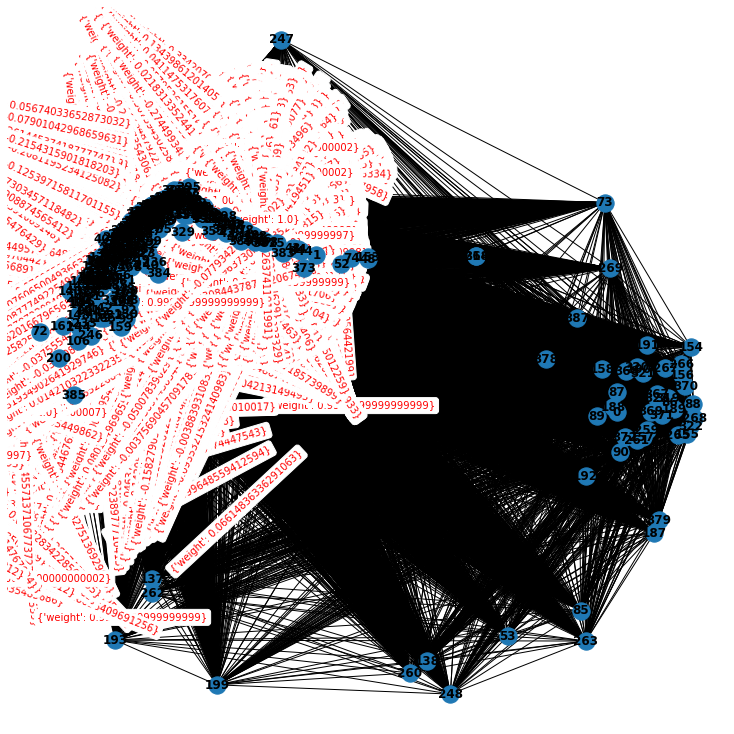

In [ ]:
draw_graphs(sim_matrix)

In [92]:
scores = calculate_score(sim_matrix)
final = ranked_sentences(sentences, scores, n = 10)

In [93]:
final

[['D4',
  'F4',
  'G4.B-4.E-5.G5.G3.B-3.E-4',
  'F5.D5.B-4.F4',
  'B-0.B-1',
  'F2',
  'B-2',
  'D3',
  'E3',
  'B-4.B-5.F3',
  'D5.F5',
  'D4.B-3',
  'G3',
  'F3',
  'B-3.B-4.D3',
  'B-3.B-4.B-2',
  'B-3.B-4.F2',
  'F3',
  'D4.F4',
  'B-1'],
 ['D5.D3',
  'F4',
  'B-4.D5.F5',
  'F3',
  'B-2',
  'D3',
  'F3',
  'B-3',
  'D4',
  'F4',
  'G4.B-4.E-5.G5.G3.B-3.E-4',
  'F5.D5.B-4.F4',
  'B-0.B-1',
  'F2',
  'B-2',
  'D3',
  'E3',
  'B-4.B-5.F3',
  'D5.F5',
  'D4.B-3'],
 ['G#2',
  'F3',
  'E3',
  'G2.E-2',
  'E-3',
  'F#3',
  'G3',
  'C#4',
  'E-4',
  'G4',
  'G3.E-4',
  'C#5',
  'E-5',
  'G#5.G#4',
  'E3.C#4.E4',
  'G#3',
  'C#5',
  'C5',
  'B4',
  'A3'],
 ['F#5.E-5',
  'C5.A4',
  'D4.B-3',
  'F#3.E-3',
  'E-2.B-2',
  'B-3',
  'B3',
  'A3',
  'B-3',
  'E-4',
  'C#4',
  'D4',
  'E-4',
  'F#4',
  'G4',
  'B-4',
  'G#4',
  'B4',
  'D5',
  'E-5'],
 ['A3',
  'B-3',
  'C#4',
  'F#4.C#5',
  'B3',
  'G#3',
  'B-3',
  'B3',
  'C#3',
  'F#3',
  'B-3',
  'E-4',
  'F4',
  'F#4',
  'G#4',
  'B-4',
  'B4

In [94]:
int_list = []
for notes in final:
  int_list.append([note_to_index[note] for note in notes])
print(int_list)

[[7, 14, 274, 275, 96, 21, 4, 1, 28, 135, 95, 58, 6, 5, 543, 169, 285, 5, 68, 53], [107, 14, 133, 5, 4, 1, 5, 2, 7, 14, 274, 275, 96, 21, 4, 1, 28, 135, 95, 58], [18, 5, 28, 1868, 35, 29, 6, 9, 13, 8, 784, 10, 16, 172, 1869, 12, 10, 31, 38, 15], [763, 452, 58, 1844, 367, 2, 37, 15, 2, 13, 9, 7, 13, 23, 8, 20, 22, 38, 26, 16], [15, 2, 9, 1850, 37, 12, 2, 37, 3, 29, 2, 13, 14, 23, 22, 20, 38, 10, 16, 17], [128, 129, 108, 53, 66, 21, 4, 87, 276, 277, 66, 58, 6, 5, 1, 4, 130, 21, 131, 132], [28, 273, 66, 58, 6, 5, 1, 4, 130, 21, 131, 132, 107, 14, 133, 5, 4, 1, 5, 2], [542, 273, 66, 58, 6, 5, 1, 4, 130, 21, 131, 132, 107, 14, 133, 5, 4, 1, 5, 2], [4, 1, 28, 72, 5, 126, 127, 87, 128, 129, 108, 53, 66, 21, 4, 87, 276, 277, 66, 58], [128, 129, 108, 53, 66, 21, 4, 1, 542, 273, 66, 58, 6, 5, 1, 4, 130, 21, 131, 132]]


In [95]:
with open('./int_list.txt' , 'w') as f:
  for ints in int_list:
    for i in ints:
      f.write(str(i))
      f.write(' ')
    f.write('\n')

f.close()

In [ ]:
int_list

## 결과 확인

In [168]:
sentence_list = []

for ints in int_list:
  real_sentence = ""
  for int in ints:
    real_sentence += index_to_word[int] + " "
  sentence_list.append(real_sentence)

In [169]:
sentence_list

['처럼 생각 하루하루 기다려 위해 하고 사람 그대 하루 랄랄 않고 한번 다시 마음 가지 아주 한다는 마음 소리 그렇게 ',
 '이야기 생각 어느새 마음 사람 그대 마음 사랑 처럼 생각 하루하루 기다려 위해 하고 사람 그대 하루 랄랄 않고 한번 ',
 '하나 마음 하루 미워하지 거야 하지 다시 없는 아무 이제 머물 너무 눈물 봐도 없기에 세상 너무 모든 바람 내게 ',
 '싫은 달콤한 한번 흩어지는 그림자 사랑 버린 내게 사랑 아무 없는 처럼 아무 모습 이제 있어 지금 바람 있는 눈물 ',
 '내게 사랑 없는 들은 버린 세상 사랑 버린 나를 하지 사랑 아무 생각 모습 지금 있어 바람 너무 눈물 기억 ',
 '이대로 들어 좋은 그렇게 지난 하고 사람 많이 남은 없네 지난 한번 다시 마음 그대 사람 찾아 하고 누가 행복 ',
 '하루 없던 지난 한번 다시 마음 그대 사람 찾아 하고 누가 행복 이야기 생각 어느새 마음 사람 그대 마음 사랑 ',
 '이번 없던 지난 한번 다시 마음 그대 사람 찾아 하고 누가 행복 이야기 생각 어느새 마음 사람 그대 마음 사랑 ',
 '사람 그대 하루 아침 마음 했어 싶은 많이 이대로 들어 좋은 그렇게 지난 하고 사람 많이 남은 없네 지난 한번 ',
 '이대로 들어 좋은 그렇게 지난 하고 사람 그대 이번 없던 지난 한번 다시 마음 그대 사람 찾아 하고 누가 행복 ']

## TF-IDF 계산

In [170]:
vectorizer = TfidfVectorizer()
sp_matrix = vectorizer.fit_transform(sentence_list)

In [171]:
word2id = defaultdict(lambda : 0)
for idx, feature in enumerate(vectorizer.get_feature_names()):
    word2id[feature] = idx

In [172]:
important = []
for i, sent in enumerate(sentence_list):
    # print('====== document[%d] ======' % i)
    important.append([ (token, sp_matrix[i, word2id[token]]) for token in sent.split() ] )

In [173]:
important = sum(important, [])

In [ ]:
important

In [174]:
important.sort(key = lambda x: x[1], reverse = True)

In [175]:
important

[('많이', 0.47126524017423427),
 ('많이', 0.47126524017423427),
 ('마음', 0.44946812825033355),
 ('마음', 0.44946812825033355),
 ('마음', 0.44946812825033355),
 ('마음', 0.44028483291606624),
 ('마음', 0.44028483291606624),
 ('마음', 0.44028483291606624),
 ('사랑', 0.4383207290434465),
 ('사랑', 0.4383207290434465),
 ('사랑', 0.4383207290434465),
 ('너무', 0.429605975463538),
 ('너무', 0.429605975463538),
 ('버린', 0.41832219983758684),
 ('버린', 0.41832219983758684),
 ('지난', 0.3827465261250538),
 ('지난', 0.3827465261250538),
 ('아무', 0.3815373586875195),
 ('아무', 0.3815373586875195),
 ('지난', 0.3792311937513059),
 ('지난', 0.3792311937513059),
 ('생각', 0.3663005195961021),
 ('생각', 0.3663005195961021),
 ('지난', 0.32919652798122917),
 ('지난', 0.32919652798122917),
 ('그대', 0.329039945729342),
 ('사람', 0.329039945729342),
 ('사람', 0.329039945729342),
 ('그대', 0.329039945729342),
 ('그대', 0.32231717539595606),
 ('사람', 0.32231717539595606),
 ('사람', 0.32231717539595606),
 ('그대', 0.32231717539595606),
 ('하고', 0.3141911065804482),
 ('사

## 중복값 제거

In [176]:
keywords = []
for keyword, _ in important:
  if keyword in keywords:
    continue
  keywords.append(keyword)

print(keywords)

['많이', '마음', '사랑', '너무', '버린', '지난', '아무', '생각', '그대', '사람', '하고', '가지', '아주', '한다는', '소리', '이번', '아침', '했어', '싶은', '남은', '없네', '하루하루', '기다려', '위해', '랄랄', '않고', '싫은', '달콤한', '흩어지는', '그림자', '있는', '하나', '미워하지', '거야', '머물', '봐도', '없기에', '모든', '없던', '이야기', '어느새', '들은', '나를', '기억', '이대로', '들어', '좋은', '처럼', '찾아', '누가', '행복', '모습', '이제', '있어', '지금', '하지', '세상', '그렇게', '하루', '내게', '없는', '바람', '눈물', '다시', '한번']


In [178]:
keywords[:10]

['많이', '마음', '사랑', '너무', '버린', '지난', '아무', '생각', '그대', '사람']

In [ ]:
vector = CountVectorizer()
print(vector.fit_transform(sentence_list).toarray())

[[1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1
  2 0 0 0 1 0 0 0 0 0 0]
 [0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 2 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 2 0 2
  2 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 0 2 0 0 0 0
  1 0 0 0 0 0 1 0 1 1 1]
 [0 0 0 0 0 0 0 2 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 2 0 0 0 0 1 0
  0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 3 0 1 0 1 0 0
  0 0 0 0 0 0 0 1 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 1 1 0 2 0 2 2 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1
  1 0 0 1 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 2 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 2
  3 0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 2 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 2
  3 0 1 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 1 1 0 0 2 0 2 1 0 0 0 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 1
  1 0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 1 1 0 2 0 2 2 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 2
  1 0 1 0 0 1 0 0 0 0 0]]


In [ ]:
tfidfv = TfidfVectorizer().fit(sentence_list)
print(tfidfv.transform(sentence_list).toarray())
print(tfidfv.vocabulary_)

[[0.38742007 0.         0.         0.32934245 0.         0.
  0.23005811 0.         0.         0.         0.         0.
  0.32934245 0.         0.         0.18885139 0.18885139 0.
  0.         0.38742007 0.         0.         0.20797803 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.23005811 0.         0.18885139
  0.34396099 0.         0.         0.         0.32934245 0.
  0.         0.         0.         0.         0.        ]
 [0.         0.25789217 0.         0.29477372 0.         0.
  0.20591055 0.         0.         0.         0.         0.
  0.29477372 0.         0.         0.338058   0.169029   0.
  0.         0.         0.         0.         0.         0.25789217
  0.         0.         0.         0.         0.         0.20591055
  0.         0.         0.         0.4118211  0.         0.338058
  0.30785786 0.         0.         0.         0.29477372 0.
  0.         0.         0.         0.         0.        ]
 [0.         0

In [ ]:
a = tfidfv.transform(sentence_list).toarray()

a.shape

(10, 47)